# Convert nmat to midi

I want to see if I can get a baseline model working. I'll use the same data as in the previous notebook, but I'll use a simpler model.

First I need to understand the ABC-notation-thingie.

In [43]:
import muspy as mp
import pickle as pkl

import muspy as mp
import pickle as pkl

def nmat_to_midi(data, save=True):

    scale = 8
    pieces = list(data.keys())

    for track_name in pieces:
        music = mp.Music() # Create new Music object for each piece
        track = mp.Track() # Create new Track object for each piece
        track_data = data[track_name]

        for note in track_data['nmat']:
            note = mp.Note(time=scale*note[0], pitch=note[2], duration=int(scale*(max(note[1]-note[0], 0.5))))
            track.notes.append(note)

        music.tracks.append(track) # Append the track to the current Music object
        music.write_midi(f'midi/{track_name}')


# the script
with open('data/dataset.pkl', 'rb') as f:
    data = pkl.load(f)

# pick the 10 random samples from "data"
# NOTE: Here I am picking the 1000 first samples!!!
top_ten_samples = dict(list(data.items())[:1000])

# convert the samples to midi
nmat_to_midi(top_ten_samples)

# Convert midi to ABC

In [44]:
import os
import subprocess
import pathlib


# specify your directories here
cwd = pathlib.Path.cwd()
midi_dir = cwd / "midi"
abc_dir = cwd / "abc"

# create abc_dir if it doesn't exist
os.makedirs(abc_dir, exist_ok=True)

# convert all midi files to abc, and save them to the abc_dir
for file in os.listdir(midi_dir):
    if file.endswith(".mid"):
        base = os.path.splitext(file)[0]
        input_file = os.path.join(midi_dir, file)
        output_file = os.path.join(abc_dir, base + ".abc")

        #print(f"Processing {input_file}")
        subprocess.run(["midi2abc", "-o", output_file, input_file])


# Super regex

In [45]:
import re

def regex_split(abc):
    # Regular expression pattern
    expressions = ["~","|","-",
      "\|[\[]?1|:\|[\[]2", #first and second endings
      '\"\(?[A-G|a-g][b|\#]?[m|d|a|7]?(6|7|b9)?\)?(/[A-G|a-g][b|\#]?[m|7]?)?\"', # chords between ""
      # "\|Y:\s*(?<=[ABCDEFG])\s(?=[ABCDEFG])?"
      "/?(2|3|4|5|6|7|8|9|12|16)",#duration
      "M:\d/\d", # meter
      "L:1/(4|8|16)", #base duration
      "K:[ABCDEFG](maj|min|m|dor)?", #key
      ":?\|:?", # vertical bar or repetition
      "\([\d]|", # triplets like this (3 
      "[\^\_\=]?[ABCDEFG][,]?", #low octave notes
      "[\^\_\=]?[abcdefg][']?", #high octave notes
      "z", # pause
      "(>|<)", # broken rhythm
      "\[|\]", # square brackets
    ]
    pattern = "|".join(expressions)

    REGEX = re.compile(pattern)

    # remove empty chords
    abc = re.sub('" "','',abc)
    # remove spaces
    abc = re.sub(' ','',abc)

    # replace + with # for sharps
    abc = re.sub(r"c\+", "c#", abc)
    abc = re.sub(r"d\+", "d#", abc)
    abc = re.sub(r"f\+", "f#", abc)
    abc = re.sub(r"g\+", "g#", abc)

    # replace :: with :||:
    abc = re.sub(r":[\|]?:", ":||:", abc)
    # replace \
    abc = re.sub(r"\\", "", abc)


    # remove all lines that start with %
    abc = re.sub(r'(?m)^\%.*\n?','',abc)
    # remove everything between !
    abc = re.sub(r'![^!]+!','',abc)

    # remove all lines that start with X:,T:,S:
    abc = re.sub(r'(?m)^[XTSPYNQR]:?.*\n?','',abc)
    # print(abc)

    abc = re.sub(REGEX, lambda y: y.group() + ' ', abc)
    # print(abc)

    return abc

Test the regex on one file and see what comes out?

In [15]:
abc_file = open('abc/Niko_Kotoulas__RhythmChordProg_2_A-Bm-D-G (V-vi-I-IV).abc', 'r')

total_tokens = regex_split(abc_file.read())

# print the total tokens
print(total_tokens)

# split total_tokens by space and remove empty strings
total_tokens = total_tokens.split(' ')
total_tokens = list(filter(None, total_tokens))

# print total tokens
print(total_tokens)

# print total number of unique tokens
print(set(total_tokens))

 M:4/4  
 L:1/8  
 K:D  % 2  s h a  r p s 
 V : 1 
 [  E,  B,  , A,  , E,  , A,  , , -  ]  3  /2  A,  , , /2  [  E,  B,  , A,  , E,  , A,  , , ]  3  /2  z  /2  [  E,  B,  , E,  , A,  , , ]  /2  z  [  D,  A,  , F,  , B,  , , -  ]  3  /2  B,  , , /2  [  D,  -  A,  , -  F,  , -  B,  , , -  ]  /2  |  
 [  D,  A,  , F,  , B,  , , ]  z  /2  [  D,  A,  , F,  , B,  , , ]  /2  z  [  E,  D,  A,  , D,  , D,  , , ]  3  /2  z  /2  [  D,  A,  , -  D,  , -  D,  , , -  ]  /2  [  A,  , D,  , D,  , , ]  z  /2  [  D,  A,  , D,  , D,  , , ]  /2  z  /2  |  
 z  /2  [  G,  D,  A,  , D,  , G,  , , ]  2  [  D,  A,  , D,  , G,  , , -  ]  /2  G,  , , z  /2  [  D,  A,  , D,  , G,  , , ]  /2  
 
['M:4/4', '\n', 'L:1/8', '\n', 'K:D', '%', '2', 's', 'h', 'a', 'r', 'p', 's', '\n', 'V', ':', '1', '\n', '[', 'E,', 'B,', ',', 'A,', ',', 'E,', ',', 'A,', ',', ',', '-', ']', '3', '/2', 'A,', ',', ',', '/2', '[', 'E,', 'B,', ',', 'A,', ',', 'E,', ',', 'A,', ',', ',', ']', '3', '/2', 'z', '/2', '[', 'E,', 'B,', ',', 'E,', 

# Count tokens and plot distribution

109
defaultdict(<class 'int'>, {'M:4/4': 1000, '\n': 6845, 'L:1/8': 1000, 'K:A': 252, '%': 1000, '3': 2670, 's': 1813, 'h': 813, 'a': 1226, 'r': 813, 'p': 813, 'V': 1000, ':': 1000, '1': 1060, '[': 16377, 'C,': 5989, '-': 40574, 'B,': 9890, ',': 40608, ']': 16377, '/2': 16014, 'z': 2809, 'D,': 8474, 'A,': 9339, '|': 1966, 'E,': 7190, '2': 1144, 'G,': 7306, 'b': 374, '4': 1279, 'f': 627, 'l': 187, 't': 187, 'F,': 8477, '=E,': 70, 'K:B': 303, '5': 308, 'C': 2466, 'D': 2865, 'K:E': 76, 'E': 1901, 'G': 1371, 'F': 1934, 'A': 1677, 'B': 1213, 'K:D': 174, 'd': 632, 'c': 767, 'K:C': 55, '0': 55, '^A,': 7, 'e': 310, '^F': 15, '=F': 47, 'g': 323, '=F,': 51, '=G,': 48, 'K:F': 89, '#': 80, '6': 80, '=D': 49, '=f': 14, 'K:G': 51, '^G': 7, "=d'": 4, '=G': 23, '^A': 7, '=A': 3, "c'": 60, "d'": 42, '(3': 38, '^g': 4, '>': 12, '^D,': 6, '=D,': 53, "e'": 15, "f'": 8, '=g': 25, '^d': 4, '=d': 14, '^D': 9, '^F,': 11, '=B,': 5, '=e': 6, '_e': 3, '_B,': 1, '^G,': 5, '^c': 2, '=c': 2, '=A,': 8, '=E': 30, '_D

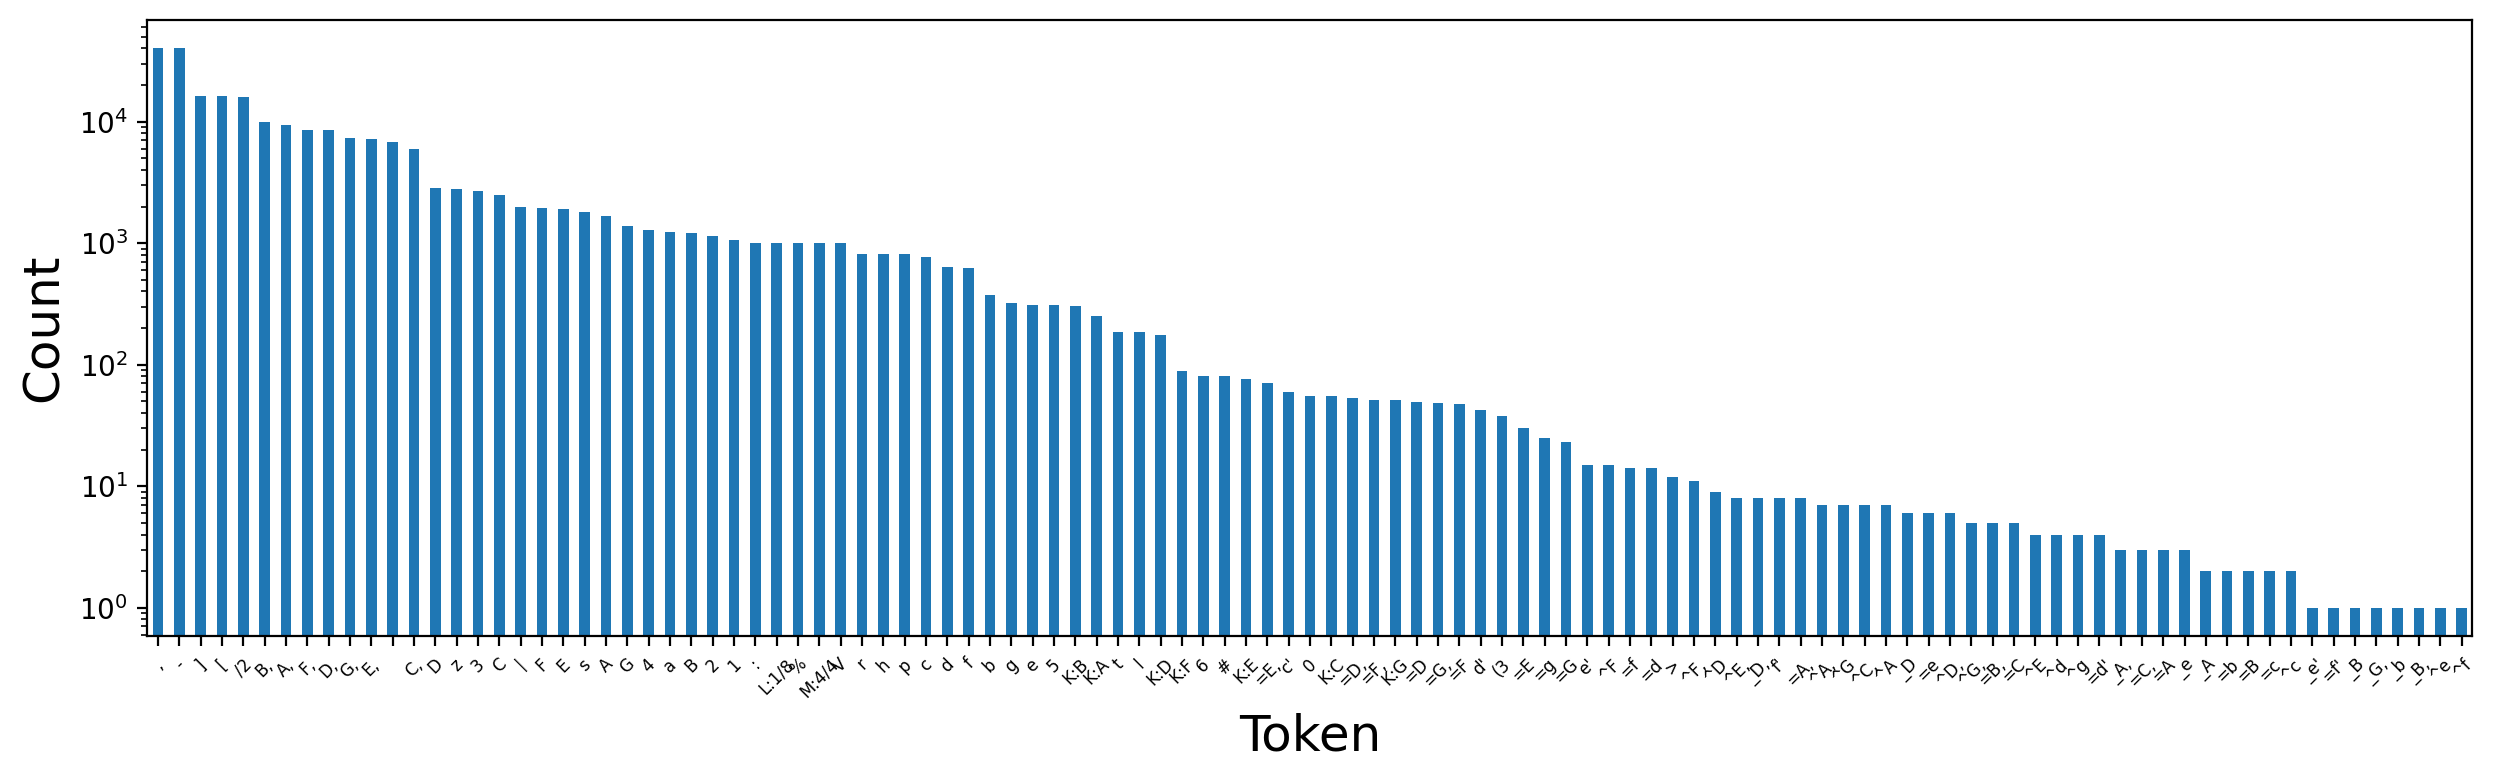

In [48]:
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt

# for all files in the 'abc' folder

total_tokens = defaultdict(int)

"""
I'd like a dataframe where each rows is a file, and each column a token count.
First I would have to create a dictionary with the token counts for each file, 
and then save the set of tokens as the columns of the dataframe.
That would allow different types of aggregation, like summing the counts of all, etc. 
"""

for path_to_file in os.listdir('abc'):
    # open the file
    with open(f'abc/{path_to_file}', 'r') as file:
        contents = file.read()
        tokens = regex_split(contents)
        # split total_tokens by space and remove empty strings
        tokens = tokens.split(' ')
        tokens = list(filter(None, tokens))
        # count the number of each token
        for token in tokens:
            total_tokens[token] += 1

# print the length of the total tokens
print(len(total_tokens))

# print the total tokens
print(total_tokens)

# convert the dictionary to a pandas dataframe
df = pd.DataFrame.from_dict(total_tokens, orient='index', columns=['count'])

# sort the dataframe by count
df = df.sort_values(by=['count'], ascending=False)

# print the dataframe
df.plot(kind='bar', figsize=(15,4))

# set the x-axis font size to 12
plt.xticks(fontsize=6)

# set the x axis label to 'token'
plt.xlabel('Token', fontsize=18)

# set the y axis label to 'count'
plt.ylabel('Count', fontsize=18)

# set y-axis to log scale
plt.yscale('log')

# rotate the x axis labels 45 degrees
plt.xticks(rotation=45)

# remove the legend
plt.legend().remove()


# Try a different counting strategy

I want to make a table where each row is a file, and the tokens are columns. Then I'll aggregate that table for various visualisations.

In [57]:
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt

items = []

for path_to_file in os.listdir('abc'):
    total_tokens = defaultdict(int)
    # open the file
    with open(f'abc/{path_to_file}', 'r') as file:
        contents = file.read()
        tokens = regex_split(contents)
        # split total_tokens by space and remove empty strings
        tokens = tokens.split(' ')
        tokens = list(filter(None, tokens))
        # count the number of each token
        for token in tokens:
            total_tokens[token] += 1
    # finally, append a tuple with the filename and the total_tokens
    items.append((path_to_file, total_tokens))

# find the total number of unique tokens
unique_tokens = set()
for item in items:
    unique_tokens.update(item[1].keys())

# add "filename" as a column
# unique_tokens.add('filename')

# make a dataframe with the unique tokens as columns
df = pd.DataFrame(columns=list(unique_tokens))

# add the counts of each token to the dataframe
for item in items:
    df = df.append(item[1], ignore_index=True)
    df = pd.concat([df, item[1]], ignore_index=True)

#df = df.fillna(0)
df

AttributeError: 'DataFrame' object has no attribute 'append'